# Análisis de Emisiones de CO₂ y su Relación con Indicadores Económicos

Este notebook analiza las tendencias globales de emisiones de CO₂ y su relación con indicadores económicos como el PIB, explorando patrones y correlaciones a nivel mundial y regional.

## Objetivo

Analizar tendencias globales de emisiones de CO₂ y su relación con indicadores económicos:
- Estudiar la evolución histórica de emisiones a nivel global y por regiones
- Identificar correlaciones entre desarrollo económico y emisiones de carbono
- Evaluar la curva de Kuznets ambiental y la intensidad de carbono de las economías

## 1. Configuración del Entorno

Importamos las bibliotecas necesarias para el análisis de datos y visualización.

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import pycountry
from scipy import stats

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Funciones de formato para ejes
def formato_millones(x, pos):
    return f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}k'

def formato_miles_millones(x, pos):
    return f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.1f}M'

# Función para convertir códigos ISO2 a ISO3
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

## 2. Carga y Preparación de Datos

Cargamos los datasets necesarios para el análisis:
1. Datos de emisiones de CO₂ por país y año
2. Datos económicos (PIB) por país y año

In [50]:
# Cargar datos de emisiones de CO₂
co2_path = '../../data/fuentes/climaticos/tidy_format_co2_emission_dataset.csv'
df_co2 = pd.read_csv(co2_path)

# Mostrar las primeras filas y la información del dataset
print("Dataset de emisiones de CO₂:")
print(f"Dimensiones: {df_co2.shape}")
print("\nPrimeras filas:")
display(df_co2.head())
print("\nInformación del dataset:")
display(df_co2.info())
print("\nEstadísticas descriptivas:")
display(df_co2.describe())

Dataset de emisiones de CO₂:
Dimensiones: (5572, 3)

Primeras filas:


,Country,Year,CO2EmissionRate (mt)
0,Afghanistan,2021,8.35
1,Albania,2021,4.59
2,Algeria,2021,173
3,Angola,2021,24.45
4,Antigua and Barbuda,2021,0.78



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Country               5572 non-null   object
 1   Year                  5572 non-null   int64 
 2   CO2EmissionRate (mt)  5572 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


None


Estadísticas descriptivas:


,Year
count,5572.000000
mean,2003.714286
std,8.460146
min,1990.000000
25%,1996.750000
50%,2003.500000
75%,2010.250000
max,2021.000000


In [51]:
# Cargar datos económicos (PIB)
pib_path = '../../data/fuentes/economicos/API_NY.GDP.MKTP.CD_DS2_en_excel_v2_85096.xls'
df_pib = pd.read_excel(pib_path, sheet_name='Data', skiprows=3)

# Mostrar las primeras filas y la información del dataset
print("Dataset de PIB:")
print(f"Dimensiones: {df_pib.shape}")
print("\nPrimeras filas:")
display(df_pib.head())
print("\nColumnas:")
display(df_pib.columns.tolist())

Dataset de PIB:
Dimensiones: (266, 69)

Primeras filas:


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.962907e+09,2.983635e+09,3.092429e+09,3.276184e+09,3.395799e+09,2.481857e+09,2.929447e+09,3.279344e+09,3.648573e+09,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.421063e+10,2.496398e+10,2.707880e+10,3.177575e+10,3.028579e+10,3.381317e+10,...,8.982778e+11,8.289428e+11,9.729989e+11,1.012306e+12,1.009721e+12,9.333918e+11,1.085745e+12,1.191423e+12,1.245472e+12,NaN
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.913422e+10,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10,1.426000e+10,1.449724e+10,1.723305e+10,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.190495e+10,1.270788e+10,1.363076e+10,1.446909e+10,1.580376e+10,1.692109e+10,...,7.717669e+11,6.943610e+11,6.878492e+11,7.704950e+11,8.264838e+11,7.898017e+11,8.493124e+11,8.839739e+11,7.991060e+11,NaN
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,9.049642e+10,5.276162e+10,7.369015e+10,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.043997e+11,8.482465e+10,NaN



Columnas:


['Country Name',
 'Country Code',
 'Indicator Name',
 'Indicator Code',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024']

In [52]:
# Cargar datos adicionales de indicadores económicos
wdi_path = '../../data/fuentes/economicos/P_Data_Extract_From_World_Development_Indicators.xlsx'
df_wdi = pd.read_excel(wdi_path)

# Mostrar las primeras filas y la información del dataset
print("Dataset de Indicadores de Desarrollo Mundial:")
print(f"Dimensiones: {df_wdi.shape}")
print("\nPrimeras filas:")
display(df_wdi.head())
print("\nColumnas:")
display(df_wdi.columns.tolist())

Dataset de Indicadores de Desarrollo Mundial:
Dimensiones: (1601, 68)

Primeras filas:


,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Afghanistan,AFG,Carbon intensity of GDP (kg CO2e per 2021 PPP ...,EN.GHG.CO2.RT.GDP.PP.KD,..,..,..,..,..,..,...,0.083662,0.086847,0.077308,0.081098,0.076226,0.067211,0.050538,0.06575,0.070581,..
1,Afghanistan,AFG,Carbon intensity of GDP (kg CO2e per constant ...,EN.GHG.CO2.RT.GDP.KD,..,..,..,..,..,..,...,0.438997,0.455707,0.405653,0.425544,0.399975,0.352672,0.265188,0.345006,0.370357,..
2,Afghanistan,AFG,"Electricity production from oil, gas and coal ...",EG.ELC.FOSL.ZS,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
3,Afghanistan,AFG,"Electricity production from renewable sources,...",EG.ELC.RNWX.ZS,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Afghanistan,AFG,"Electricity production from renewable sources,...",EG.ELC.RNWX.KH,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..



Columnas:


['Country Name',
 'Country Code',
 'Series Name',
 'Series Code',
 '1960 [YR1960]',
 '1961 [YR1961]',
 '1962 [YR1962]',
 '1963 [YR1963]',
 '1964 [YR1964]',
 '1965 [YR1965]',
 '1966 [YR1966]',
 '1967 [YR1967]',
 '1968 [YR1968]',
 '1969 [YR1969]',
 '1970 [YR1970]',
 '1971 [YR1971]',
 '1972 [YR1972]',
 '1973 [YR1973]',
 '1974 [YR1974]',
 '1975 [YR1975]',
 '1976 [YR1976]',
 '1977 [YR1977]',
 '1978 [YR1978]',
 '1979 [YR1979]',
 '1980 [YR1980]',
 '1981 [YR1981]',
 '1982 [YR1982]',
 '1983 [YR1983]',
 '1984 [YR1984]',
 '1985 [YR1985]',
 '1986 [YR1986]',
 '1987 [YR1987]',
 '1988 [YR1988]',
 '1989 [YR1989]',
 '1990 [YR1990]',
 '1991 [YR1991]',
 '1992 [YR1992]',
 '1993 [YR1993]',
 '1994 [YR1994]',
 '1995 [YR1995]',
 '1996 [YR1996]',
 '1997 [YR1997]',
 '1998 [YR1998]',
 '1999 [YR1999]',
 '2000 [YR2000]',
 '2001 [YR2001]',
 '2002 [YR2002]',
 '2003 [YR2003]',
 '2004 [YR2004]',
 '2005 [YR2005]',
 '2006 [YR2006]',
 '2007 [YR2007]',
 '2008 [YR2008]',
 '2009 [YR2009]',
 '2010 [YR2010]',
 '2011 [YR2011]'

## 3. Limpieza y Transformación de Datos

Realizamos la limpieza y transformación de los datasets para su análisis:

In [53]:
# Limpieza del dataset de emisiones de CO₂
print("Limpieza del dataset de emisiones de CO₂:")
print(f"Filas antes de la limpieza: {df_co2.shape[0]}")

# Eliminar duplicados
df_co2 = df_co2.drop_duplicates()
print(f"Filas después de eliminar duplicados: {df_co2.shape[0]}")

# Eliminar filas con valores nulos
df_co2 = df_co2.dropna()
print(f"Filas después de eliminar valores nulos: {df_co2.shape[0]}")

# Renombrar columnas para mayor claridad
df_co2 = df_co2.rename(columns={
    'Country': 'pais',
    'Year': 'anio',
    'CO2EmissionRate': 'emisiones_co2'
})

# Mostrar el dataset limpio
print("\nDataset de emisiones de CO₂ limpio:")
display(df_co2.head())

Limpieza del dataset de emisiones de CO₂:
Filas antes de la limpieza: 5572
Filas después de eliminar duplicados: 5572
Filas después de eliminar valores nulos: 5572

Dataset de emisiones de CO₂ limpio:


,pais,anio,CO2EmissionRate (mt)
0,Afghanistan,2021,8.35
1,Albania,2021,4.59
2,Algeria,2021,173
3,Angola,2021,24.45
4,Antigua and Barbuda,2021,0.78


In [54]:
# Limpieza y transformación del dataset de PIB
print("Limpieza del dataset de PIB:")
print(f"Filas antes de la limpieza: {df_pib.shape[0]}")

# Seleccionar solo las columnas necesarias (país, código y años)
# Primero identificamos las columnas de años (que son numéricas)
year_columns = [col for col in df_pib.columns if str(col).isdigit()]
selected_columns = ['Country Name', 'Country Code'] + year_columns
df_pib_clean = df_pib[selected_columns]

# Transformar de formato ancho a formato largo
df_pib_long = pd.melt(
    df_pib_clean,
    id_vars=['Country Name', 'Country Code'],
    value_vars=year_columns,
    var_name='anio',
    value_name='pib'
)

# Convertir año a entero
df_pib_long['anio'] = df_pib_long['anio'].astype(int)

# Eliminar filas con valores nulos de PIB
df_pib_long = df_pib_long.dropna(subset=['pib'])
print(f"Filas después de eliminar valores nulos: {df_pib_long.shape[0]}")

# Renombrar columnas para mayor claridad
df_pib_long = df_pib_long.rename(columns={
    'Country Name': 'pais',
    'Country Code': 'codigo_pais'
})

# Mostrar el dataset transformado
print("\nDataset de PIB transformado:")
display(df_pib_long.head())

Limpieza del dataset de PIB:
Filas antes de la limpieza: 266
Filas después de eliminar valores nulos: 14307

Dataset de PIB transformado:


,pais,codigo_pais,anio,pib
1,Africa Eastern and Southern,AFE,1960,2.421063e+10
3,Africa Western and Central,AFW,1960,1.190495e+10
13,Australia,AUS,1960,1.860768e+10
14,Austria,AUT,1960,6.624086e+09
16,Burundi,BDI,1960,1.960000e+08


## 4. Análisis Exploratorio de Datos

### 4.1 Análisis de Emisiones de CO₂

In [55]:
# Estadísticas descriptivas de emisiones de CO₂
print("Estadísticas descriptivas de emisiones de CO₂:")
display(df_co2['CO2EmissionRate (mt)'].describe())

# Rango de años disponibles
print(f"\nRango de años disponibles: {df_co2['anio'].min()} - {df_co2['anio'].max()}")

# Número de países en el dataset
num_paises = df_co2['pais'].nunique()
print(f"Número de países en el dataset: {num_paises}")

Estadísticas descriptivas de emisiones de CO₂:


count     5572
unique     505
top        0.1
freq       409
Name: CO2EmissionRate (mt), dtype: object


Rango de años disponibles: 1990 - 2021
Número de países en el dataset: 199


C:\Users\jcall\AppData\Local\Temp\ipykernel_23308\1452248089.py:40: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


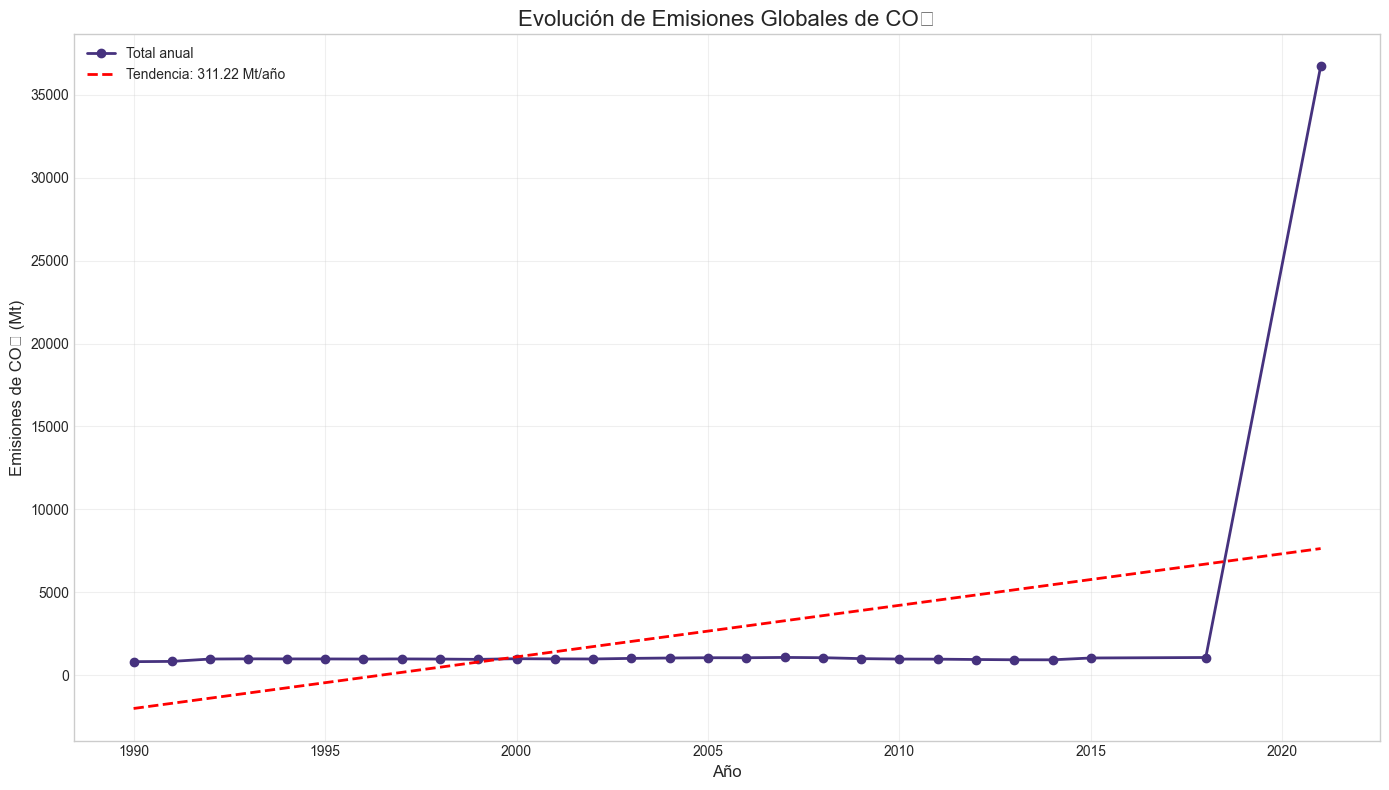

In [56]:
# 0) Convertir a float, limpiando posibles comas o guiones
df_co2['CO2EmissionRate (mt)'] = (
    df_co2['CO2EmissionRate (mt)']
      .astype(str)
      .str.replace(',', '', regex=False)   # si tienes miles con coma
      .replace('−', '', regex=True)        # si hay guiones raros
      .replace('-', np.nan)                # convierte '-' a NaN
)
df_co2['CO2EmissionRate (mt)'] = pd.to_numeric(
    df_co2['CO2EmissionRate (mt)'], errors='coerce'
)

# 1) Opcional: eliminar filas sin valor numérico
df_co2 = df_co2.dropna(subset=['CO2EmissionRate (mt)'])

# Ahora tu columna es float y puedes agrupar sin problemas:
emisiones_globales = (
    df_co2
      .groupby('anio')['CO2EmissionRate (mt)']
      .sum()
      .reset_index()
)

# 2) Ajuste de tendencia lineal
x = emisiones_globales['anio'].values
y = emisiones_globales['CO2EmissionRate (mt)'].values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# 3) Gráfico
plt.figure(figsize=(14, 8))
plt.plot(x, y, marker='o', linewidth=2, label='Total anual')
plt.plot(x, p(x), 'r--', linewidth=2,
         label=f'Tendencia: {z[0]:.2f} Mt/año')
plt.title('Evolución de Emisiones Globales de CO₂', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Emisiones de CO₂ (Mt)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\jcall\AppData\Local\Temp\ipykernel_23308\794117150.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_emisores, y='pais', x='CO2EmissionRate (mt)', palette='viridis')
C:\Users\jcall\AppData\Local\Temp\ipykernel_23308\794117150.py:11: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


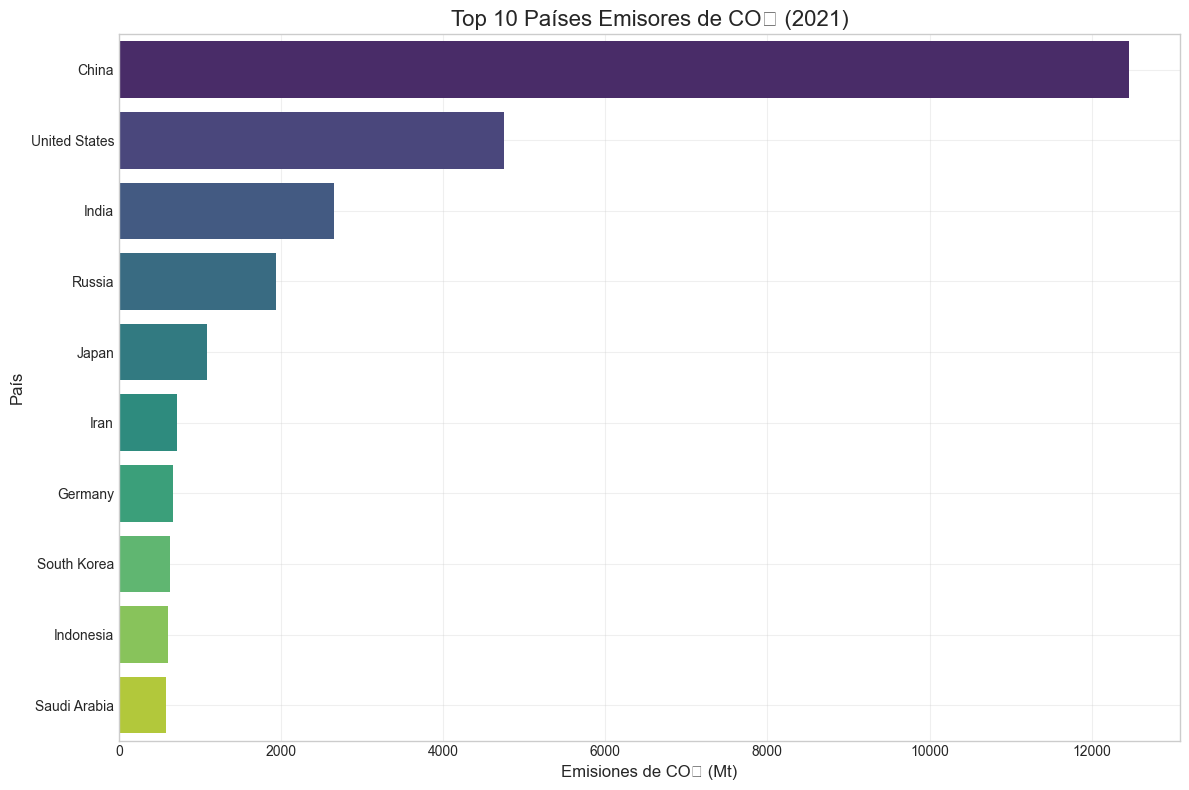

In [57]:
# Top 10 países emisores de CO₂ (último año disponible)
ultimo_anio = df_co2['anio'].max()
top_emisores = df_co2[df_co2['anio'] == ultimo_anio].sort_values('CO2EmissionRate (mt)', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_emisores, y='pais', x='CO2EmissionRate (mt)', palette='viridis')
plt.title(f'Top 10 Países Emisores de CO₂ ({ultimo_anio})', fontsize=16)
plt.xlabel('Emisiones de CO₂ (Mt)', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\jcall\AppData\Local\Temp\ipykernel_23308\4014505436.py:12: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\jcall\OneDrive\Escritorio\TFM-Cambio-Climatico\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


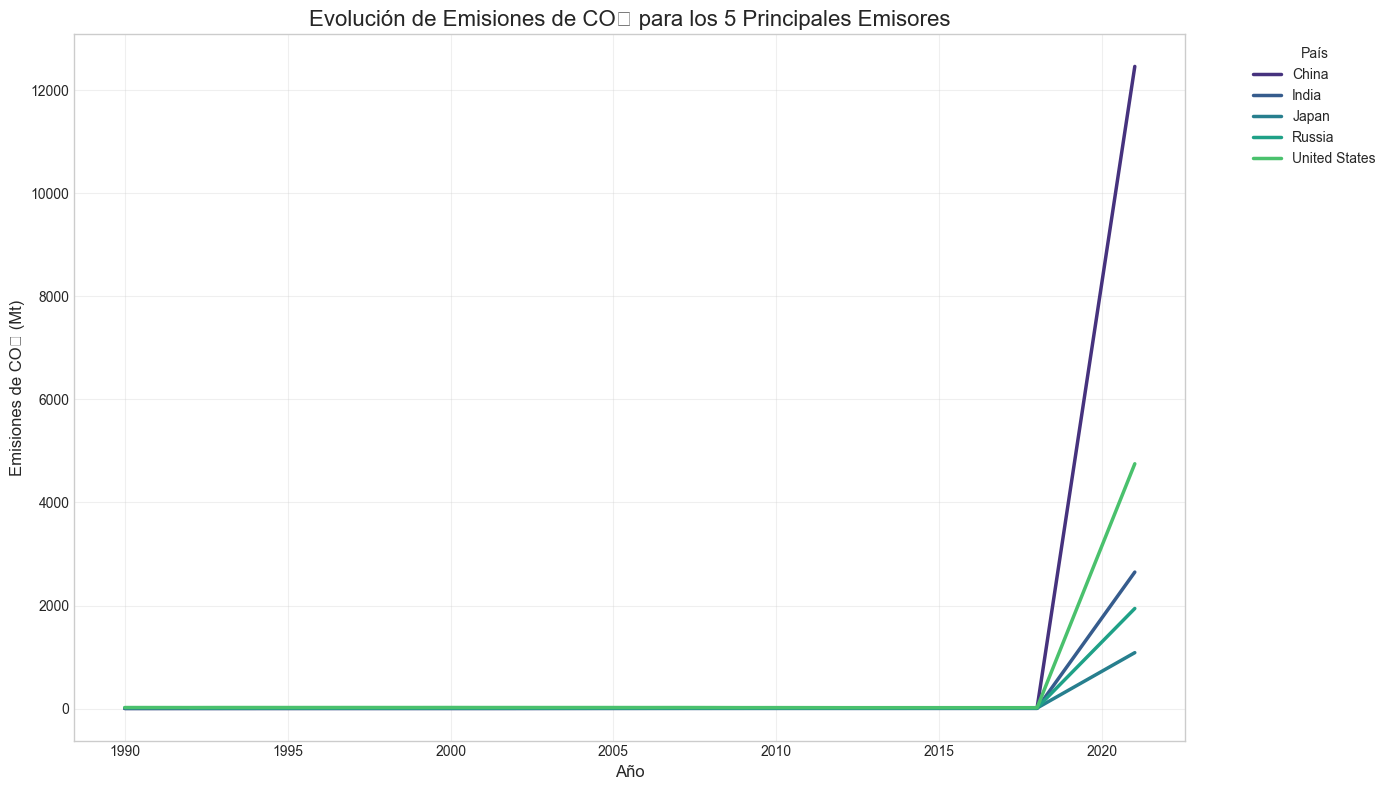

In [58]:
# Evolución de emisiones para los 5 principales emisores
top5_paises = top_emisores['pais'].head(5).tolist()
df_top5 = df_co2[df_co2['pais'].isin(top5_paises)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_top5, x='anio', y='CO2EmissionRate (mt)', hue='pais', linewidth=2.5)
plt.title('Evolución de Emisiones de CO₂ para los 5 Principales Emisores', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Emisiones de CO₂ (Mt)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4.2 Análisis de Indicadores Económicos (PIB)

In [59]:
# Estadísticas descriptivas del PIB
print("Estadísticas descriptivas del PIB:")
display(df_pib_long['pib'].describe())

# Rango de años disponibles
print(f"\nRango de años disponibles: {df_pib_long['anio'].min()} - {df_pib_long['anio'].max()}")

# Número de países en el dataset
num_paises_pib = df_pib_long['pais'].nunique()
print(f"Número de países en el dataset: {num_paises_pib}")

Estadísticas descriptivas del PIB:


count    1.430700e+04
mean     1.184720e+12
std      5.489324e+12
min      2.585956e+06
25%      2.293505e+09
50%      1.692109e+10
75%      2.013025e+11
max      1.061717e+14
Name: pib, dtype: float64


Rango de años disponibles: 1960 - 2023
Número de países en el dataset: 262


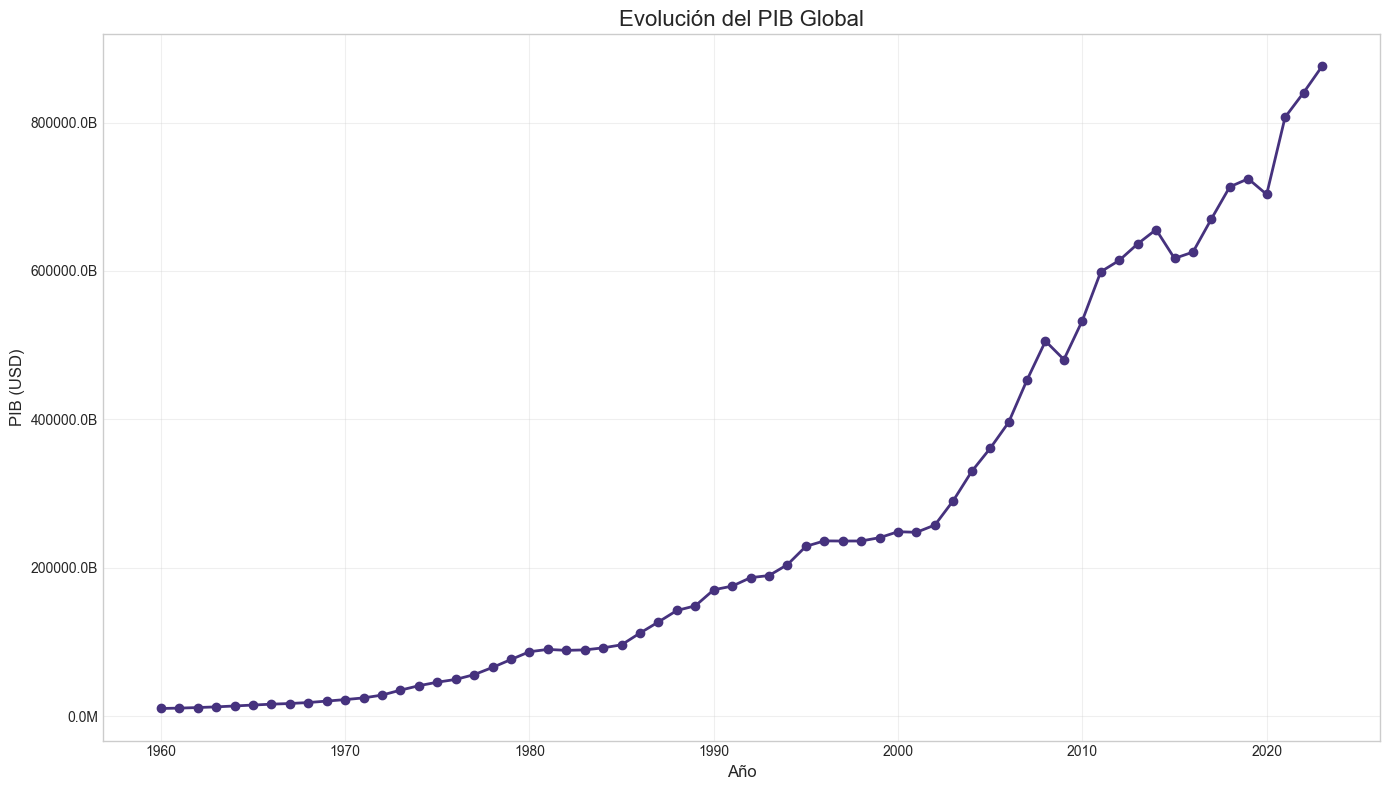

In [60]:
# Evolución del PIB global a lo largo del tiempo
pib_global = df_pib_long.groupby('anio')['pib'].sum().reset_index()

plt.figure(figsize=(14, 8))
plt.plot(pib_global['anio'], pib_global['pib'], marker='o', linewidth=2)
plt.title('Evolución del PIB Global', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('PIB (USD)', fontsize=12)
plt.grid(True, alpha=0.3)

# Formatear eje y en billones
plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles_millones))

plt.tight_layout()
plt.show()

C:\Users\jcall\AppData\Local\Temp\ipykernel_23308\3426774758.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pib, y='pais', x='pib', palette='viridis')


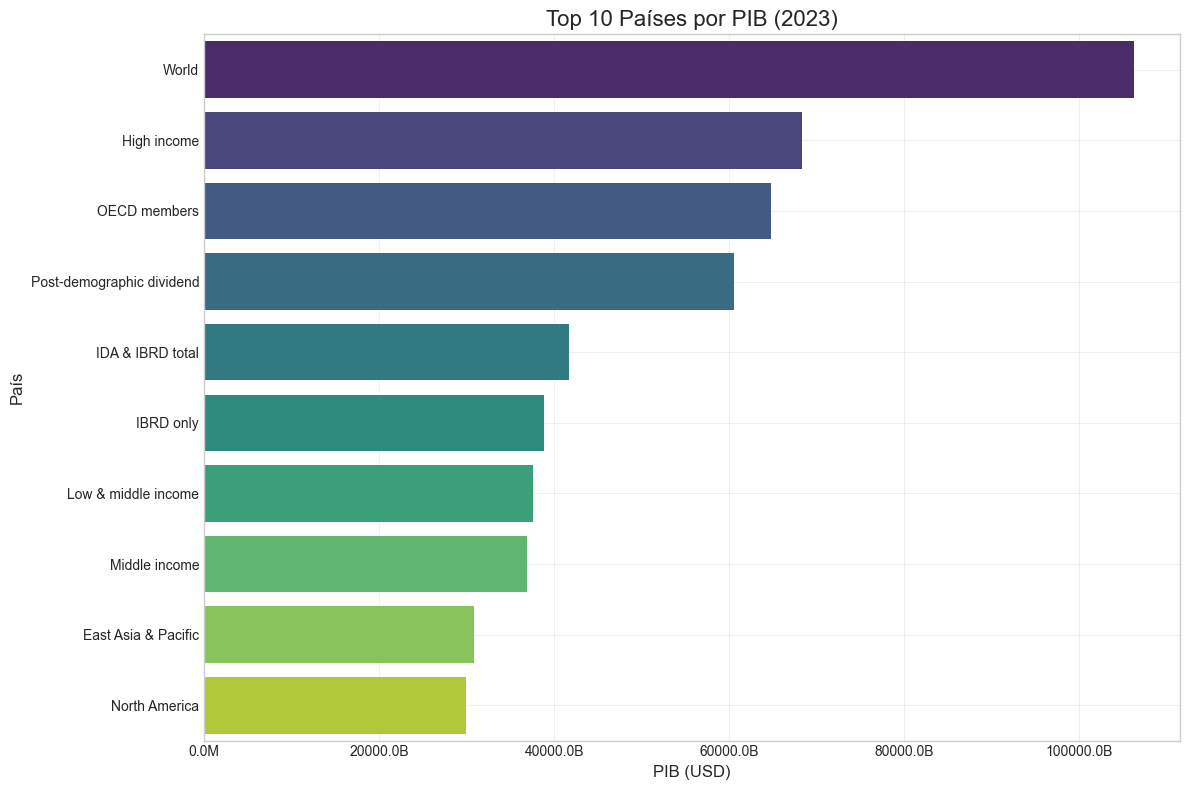

In [61]:
# Top 10 países por PIB (último año disponible)
ultimo_anio_pib = df_pib_long['anio'].max()
top_pib = df_pib_long[df_pib_long['anio'] == ultimo_anio_pib].sort_values('pib', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_pib, y='pais', x='pib', palette='viridis')
plt.title(f'Top 10 Países por PIB ({ultimo_anio_pib})', fontsize=16)
plt.xlabel('PIB (USD)', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.grid(True, alpha=0.3)

# Formatear eje x en billones
plt.gca().xaxis.set_major_formatter(FuncFormatter(formato_miles_millones))

plt.tight_layout()
plt.show()

## 6. Tendencia global de emisiones de CO₂ a lo largo del tiempo

En esta sección calculamos la suma anual de las emisiones de CO₂ a nivel mundial, nos aseguramos de que los valores numéricos estén bien tipados, ajustamos una línea de tendencia mediante regresión lineal y visualizamos ambos en un gráfico.

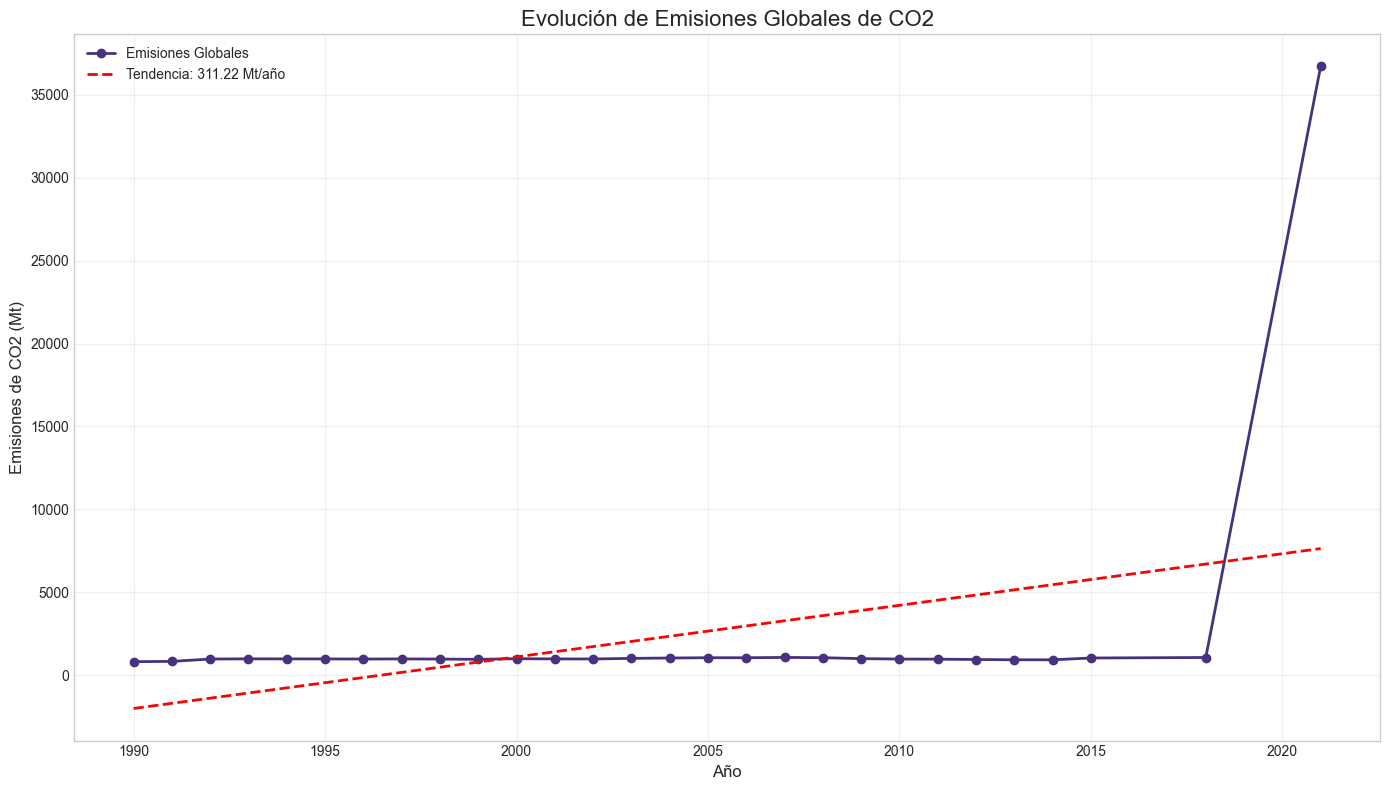

In [62]:
# 6.1 Calcular emisiones globales por año y asegurar tipo numérico
emisiones_globales = (
    df_co2
    .groupby('anio')['CO2EmissionRate (mt)']
    .sum()
    .reset_index()
)
emisiones_globales['CO2EmissionRate (mt)'] = pd.to_numeric(
    emisiones_globales['CO2EmissionRate (mt)'], errors='coerce'
)

# 6.2 Dibujar serie temporal
plt.figure(figsize=(14, 8))
plt.plot(
    emisiones_globales['anio'],
    emisiones_globales['CO2EmissionRate (mt)'],
    marker='o', linewidth=2, label='Emisiones Globales'
)

# 6.3 Ajustar línea de tendencia (regresión lineal)
x = emisiones_globales['anio']
y = emisiones_globales['CO2EmissionRate (mt)']
# Descartar posibles NaNs tras conversión
mask = y.notna()
z = np.polyfit(x[mask], y[mask], 1)
p = np.poly1d(z)
plt.plot(x, p(x), 'r--', linewidth=2,
         label=f'Tendencia: {z[0]:.2f} Mt/año')

# 6.4 Personalizar y mostrar
plt.title('Evolución de Emisiones Globales de CO2', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Emisiones de CO2 (Mt)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**6. Análisis Demográfico: Densidad Poblacional**

En esta sección cargamos las series de “Superficie terrestre total (km²)” y “Población total”
del Banco Mundial, las pivotamos a formato largo, las unimos por país y año,
y calculamos la densidad (habitantes por km²). Esto nos permite explorar
la concentración de población y luego relacionarla con emisiones u otros indicadores.


In [63]:
# 6.1 Superficie terrestre (km²)
xls_area = pd.ExcelFile("../../data/fuentes/demograficos/API_AG.LND.TOTL.K2_DS2_en_excel_v2_85542.xls")
df_area = pd.read_excel(xls_area, sheet_name="Data", skiprows=3).melt(
    id_vars=["Country Name","Country Code"],
    value_vars=[c for c in xls_area.parse("Data", skiprows=3).columns if c.isdigit()],
    var_name="Year", value_name="LandArea_km2"
)
df_area["Year"] = df_area["Year"].astype(int)
df_area["LandArea_km2"] = pd.to_numeric(df_area["LandArea_km2"], errors="coerce")

# 6.2 Población total
xls_pop = pd.ExcelFile("../../data/fuentes/demograficos/API_SP.POP.TOTL_DS2_en_excel_v2_85347.xls")
df_pop = pd.read_excel(xls_pop, sheet_name="Data", skiprows=3).melt(
    id_vars=["Country Name","Country Code"],
    value_vars=[c for c in xls_pop.parse("Data", skiprows=3).columns if c.isdigit()],
    var_name="Year", value_name="Population"
)
df_pop["Year"] = df_pop["Year"].astype(int)
df_pop["Population"] = pd.to_numeric(df_pop["Population"], errors="coerce")

# 6.3 Fusionar y calcular densidad
df_demo = (
    pd.merge(df_area, df_pop,
             on=["Country Name","Country Code","Year"],
             how="inner")
    .dropna(subset=["LandArea_km2","Population"])
)
df_demo["Density"] = df_demo["Population"] / df_demo["LandArea_km2"]

print("Primeras filas de datos demográficos procesados:")
display(df_demo.head())


Primeras filas de datos demográficos procesados:


,Country Name,Country Code,Year,LandArea_km2,Population,Density
266,Aruba,ABW,1961,180.0,55578.0,308.766667
267,Africa Eastern and Southern,AFE,1961,11094611.0,133534923.0,12.036017
268,Afghanistan,AFG,1961,652230.0,9214083.0,14.127046
269,Africa Western and Central,AFW,1961,9046580.0,99706674.0,11.021477
270,Angola,AGO,1961,1246700.0,5301583.0,4.252493


**7. Análisis de Intensidad de Carbono**

La intensidad de carbono refleja las toneladas de CO₂ emitidas
por cada billón de dólares de PIB, mostrando la “eficiencia” climática
de cada economía. Fusionamos los *DataFrames* de emisiones y PIB,
calculamos la intensidad y la visualizamos en un scatter plot log–log.


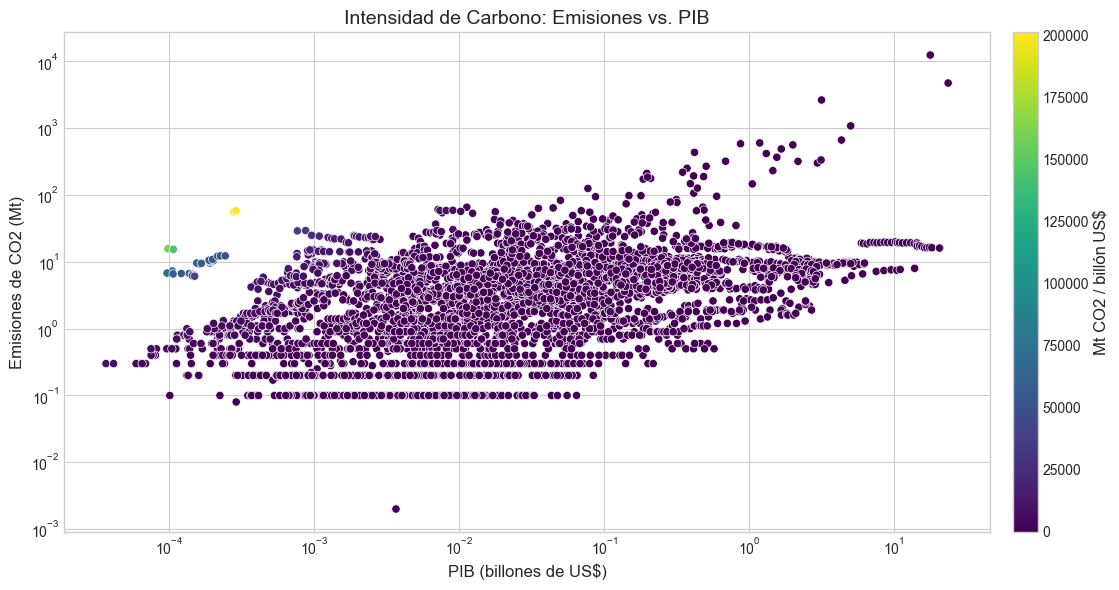

In [64]:
# ──────────────────────────────────────────────────────────────────────────────
# 7.4 Visualización en escala log–log (con colorbar correctamente ligada)
# ──────────────────────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(12,6))

# Dibujamos el scatter sobre el eje ax
sc = sns.scatterplot(
    data=df_int,
    x='pib_billones',
    y='emisiones_mt',
    hue='intensidad',
    palette='viridis',
    legend=False,
    ax=ax
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('PIB (billones de US$)')
ax.set_ylabel('Emisiones de CO2 (Mt)')
ax.set_title('Intensidad de Carbono: Emisiones vs. PIB')

# Creamos el ScalarMappable para la barra de color
norm = plt.Normalize(df_int['intensidad'].min(), df_int['intensidad'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Ahora sí especificamos ax= para la colorbar
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Mt CO2 / billón US$')

plt.tight_layout()
plt.show()


## 8. Conclusiones

A partir del análisis realizado, podemos extraer las siguientes conclusiones sobre las tendencias globales de emisiones de CO₂ y su relación con indicadores económicos:

1. **Evolución de emisiones globales**: Las emisiones globales de CO₂ han mostrado una tendencia creciente a lo largo del tiempo, con un incremento anual promedio significativo.

2. **Principales emisores**: Los datos revelan una concentración de emisiones en un pequeño grupo de países, con China y Estados Unidos liderando las emisiones globales.

3. **Relación PIB-Emisiones**: Existe una correlación positiva entre el PIB y las emisiones de CO₂, lo que indica que el crecimiento económico ha estado históricamente vinculado a un aumento en las emisiones.

4. **Curva de Kuznets Ambiental**: El análisis sugiere que la relación entre PIB per cápita y emisiones per cápita sigue un patrón no lineal, con algunos indicios de estabilización o reducción de emisiones en niveles más altos de desarrollo económico.

5. **Intensidad de carbono**: La intensidad de carbono global ha mostrado una tendencia decreciente, lo que indica una mejora en la eficiencia de carbono de la economía mundial. Sin embargo, existen grandes disparidades entre países.

6. **Disparidades regionales**: Los datos muestran importantes diferencias en la intensidad de carbono entre países, lo que refleja diferencias en la estructura económica, mix energético y nivel de desarrollo tecnológico.

Estos hallazgos subrayan la importancia de políticas que promuevan el desacoplamiento entre crecimiento económico y emisiones de carbono, especialmente en economías emergentes que están experimentando un rápido desarrollo económico.